# Home detection

Select the evening/nighttime interval that is considered home-time.
Time dimension is discretized into 30 minutes intervals and indexed from 0 to 47.
The home location (cell) is defined as the cell where a user appears the most between 20:00 (40) and 08:00 (16).  

## Validation by census

- Census data is downloaded from [Japanese Government Statistics](https://www.e-stat.go.jp/en/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001136464&cycle=0&year=20200&month=24101210&tclass1=000001136466).

In [3]:
import re
import yaml
import pandas as pd
import geopandas as gpd
import seaborn as sns


def transform_ward_name(name: str) -> str:
    """
    >>> transform_ward_name('2068_Nagoya-shi Chikusa-ku')
    Chikusa Ward
    """
    result = name
    if m := re.search(r"shi (.+)-ku", name):
        result = m.group(1) + " Ward"
    return result


def transform_shi_name(name: str) -> str:
    """
    >>> transform_ward_name('4042_Miyakojima-shi')
    Miyakojima
    """
    result = None
    if m := re.search(r"[0-9]+_(.+)-shi", name):
        result = m.group(1)
    return result


with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)

with open("../OkabeIto.yaml") as fp:
    OkabeIto = yaml.safe_load(fp)

In [4]:
CRS = 2449
x_ratio = 0.9
y_ratio = 1.1

figure_output = "../figures"

In [5]:
homes = pd.read_csv("../output/homes.csv", engine="pyarrow")

In [7]:
grid = gpd.read_file(f"../output/grid_bl_{CRS}.geojson", engine="pyogrio")

grid_c = grid.copy()
grid_c["geometry"] = grid.centroid
grid_c.to_crs(4326, inplace=True)

grid.to_crs(4326, inplace=True)

In [8]:
wards = gpd.read_file("../data/geojson/admin8.geojson", engine="pyogrio")

cities = gpd.read_file("../data/geojson/admin7_filtered.geojson", engine="pyogrio")
cities = cities[["osm_id", "name", "geometry"]].copy()
cities.columns = ["city_osm_id", "city_name", "city_geometry"]
cities.set_geometry("city_geometry", inplace=True)

wards = wards[
    wards["geometry"].intersects(
        cities.query("city_name=='Nagoya'")["city_geometry"].tolist()[0]
    )
].copy()

In [9]:
city_area = cities[cities["city_geometry"].intersects(grid.unary_union)].copy()
city_area["city_area"] = city_area["city_geometry"].to_crs(CRS).area / 1e6
city_area["intersection_area"] = (
    city_area["city_geometry"].intersection(grid.unary_union).to_crs(CRS).area / 1e6
)
city_area["intersection_ratio"] = (
    city_area["intersection_area"] / city_area["city_area"]
)

In [10]:
less_than_30pc_cities = city_area.query("intersection_ratio < 0.3")[
    "city_name"
].tolist()
less_than_50pc_cities = city_area.query("intersection_ratio < 0.50")[
    "city_name"
].tolist()

In [11]:
grid_nw = grid_c.sjoin(wards[["osm_id", "name", "geometry"]])
grid_nw.drop("index_right", axis=1, inplace=True)

In [12]:
homes_per_cell = homes.groupby(["x", "y"])["uid"].count().reset_index()
homes_per_cell.columns = ["x", "y", "count"]

In [13]:
detected_inhabitants = (
    grid_nw.merge(homes_per_cell, on=["x", "y"]).groupby(["name"])["count"].sum()
)

In [14]:
nagoya_census = pd.read_excel(
    "../data/census/b01_01e.xlsx",
    # read only Nagoya wards
    skiprows=2082,
    nrows=16,
    header=None,
)
nagoya_census = nagoya_census[[6, 7]].copy()
nagoya_census.columns = ["original_name", "population"]

nagoya_census["name"] = nagoya_census["original_name"].apply(transform_ward_name)

In [15]:
nagoya_census = nagoya_census.merge(detected_inhabitants, on="name")
nagoya_census["population"].corr(nagoya_census["count"])

0.874375347733273

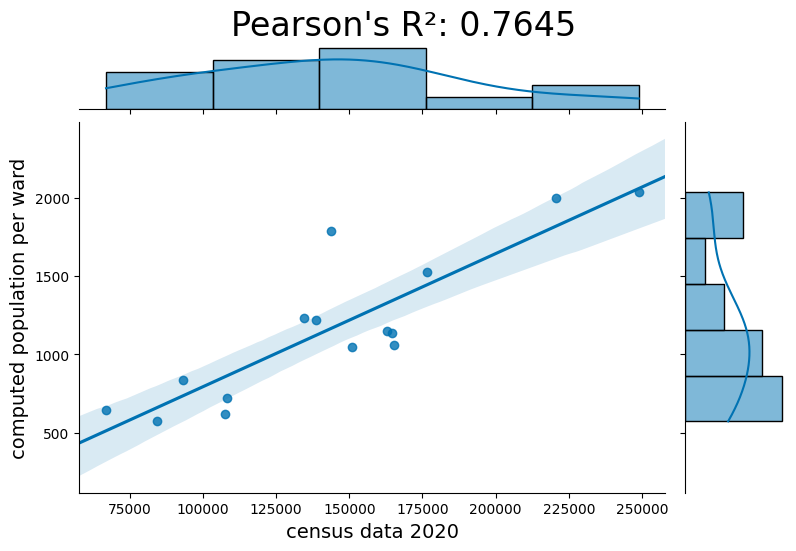

In [18]:
g = sns.jointplot(
    data=nagoya_census,
    x="population",
    y="count",
    kind="reg",
    truncate=False,
    color=OkabeIto["blue"],
    height=7,
)
g.set_axis_labels(
    xlabel="census data 2020", ylabel="computed population per ward", fontsize=14
)
g.fig.suptitle(
    "Pearson's R²:"
    + f' {round(nagoya_census["population"].corr(nagoya_census["count"])**2, 4)}',
    fontsize=24,
    y=1.05,
)

g.fig.set_size_inches(8, 5)
for i in config["formats"]:
    g.savefig(
        f"{figure_output}/population_per_ward.{i}",
        dpi=150,
        facecolor="white",
        metadata=config["metadata"] if i != "svg" else None,
    )

In [19]:
census = pd.read_excel("../data/census/b01_01e.xlsx", skiprows=15, header=None)

census = census[range(8)].copy()

census = census[census[0] == "2"].copy()
census = census.drop([0, 1, 2, 3, 4, 5], axis=1).copy()
census.columns = ["original_name", "population"]
census["population"] = pd.to_numeric(census["population"])

census["name"] = census["original_name"].apply(transform_shi_name)

In [20]:
grid_c = grid_c.sjoin(cities)
grid_c.drop("index_right", axis=1, inplace=True)

In [21]:
detected_inhabitants_full = (
    grid_c.merge(homes_per_cell, on=["x", "y"]).groupby(["city_name"])["count"].sum()
)

In [22]:
census = census.merge(detected_inhabitants_full, left_on="name", right_on="city_name")
census["population"].corr(census["count"])

0.8385334031900301

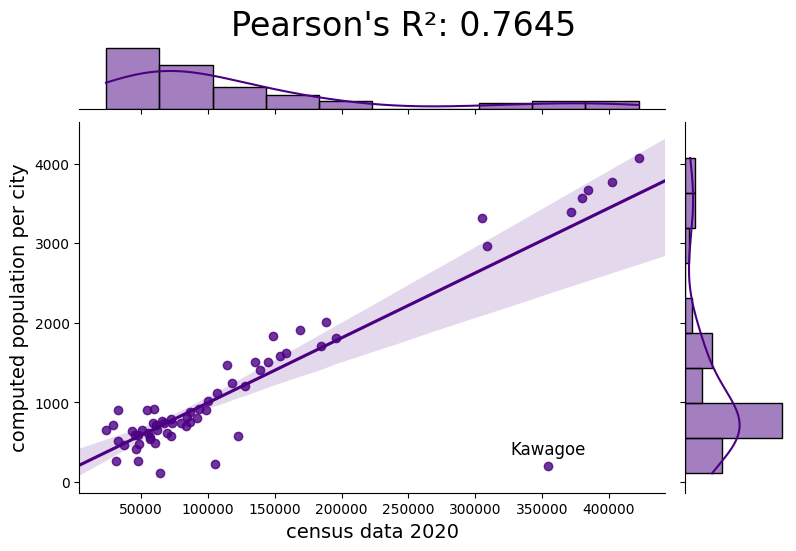

In [23]:
g = sns.jointplot(
    data=census[~census["name"].isin(less_than_50pc_cities)],
    x="population",
    y="count",
    kind="reg",
    truncate=False,
    color="indigo",
    height=7,
)
g.set_axis_labels(
    xlabel="census data 2020", ylabel="computed population per city", fontsize=14
)
g.fig.suptitle(
    "Pearson's R²:"
    + f' {round(nagoya_census["population"].corr(nagoya_census["count"])**2, 4)}',
    fontsize=24,
    y=1.05,
)
g.figure.get_axes()[0].text(
    census.query("name=='Kawagoe'").reset_index().loc[0, "population"],
    census.query("name=='Kawagoe'").reset_index().loc[0, "count"] + 100,
    "Kawagoe",
    fontsize=12,
    ha="center",
    va="bottom",
)
g.fig.set_size_inches(8, 5)
for i in config["formats"]:
    g.savefig(
        f"{figure_output}/population_per_city.{i}",
        dpi=150,
        facecolor="white",
        metadata=config["metadata"] if i != "svg" else None,
    )